In [1]:
import sys
sys.path.append('..')
import time
from astropy.table import Table
import pyfits as fits
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser
from deeplens.resnet_classifier import deeplens_classifier
from deeplens.utils.blfchallenge import classify_ground_challenge 

from sklearn import metrics

home = expanduser("~")

Using Theano backend.


In [2]:
imgs = 240

# Path to the downloaded files
# download_path=home+'/Desktop/' # To be adjusted on your machine
download_path='//Volumes/CJSTORFER/' # To be adjusted on your machine



# Path to export the data
export_path=home+'/Desktop/'   # To be adjusted on your machine


#Loads x, y dataset that belong to the previously trained CNN

d = Table.read(export_path+'catalogs_'+str(imgs)+'_RGB.hdf5', path='/ground')  

x = np.asarray(d['image']).reshape((-1,3,101,101))
print x.shape

y = np.asarray(d['is_lens']).reshape((-1,1))
print y.shape



print 'Lens(1): '+ str(np.sum(y==1))
print 'Non-lens(0): '+ str(np.sum(y==0))



(240, 3, 101, 101)
(240, 1)
Lens(1): 104
Non-lens(0): 136


In [3]:
model = deeplens_classifier()
model.load('/Users/Chris/CMUDeepLens/Trained_Sets/500imgs_100epochs_RGB/deeplens_params_final.npy', x, y)

loading from /Users/Chris/CMUDeepLens/Trained_Sets/500imgs_100epochs_RGB/deeplens_params_final.npy...
Model loaded


In [4]:
ims = np.zeros((61, 3, 101, 101))
counter = 0
 
files = 61

# Loads the images
for i in range (files):
    ims[i] = fits.getdata('/Users/Chris/Desktop/Training_Set/Lenses/cutout_{}.fits'.format(i))

# Concatenate images to catalog
x_lens_32 = ims
y_lens_32 = np.ones((61,1))

print "Done !"


Done !


In [5]:
files = 168
ims_0 = np.zeros((files, 3, 101, 101))
counter = 0
 

for i in range (files):
    ims_0[i] = fits.getdata('/Users/Chris/Desktop/Training_Set/Non-Lenses/cutout_000{:03d}.fits'.format(i))
x_nonlens = ims_0
y_nonlens = np.zeros((x_nonlens.shape[0],1))

In [6]:
x_test = np.concatenate((x_lens_32,x_nonlens))
# print x_test.shape
y_test = np.concatenate((y_lens_32,y_nonlens))
# print y_test.shape

In [7]:
print 'max test:',np.max(x_test)
print 'max:',np.max(x)

print '\nmin test:',np.min(x_test)
print 'min:',np.min(x)

print '\nmean test:',np.mean(x_test)
print 'mean:',np.mean(x)

max test: 108.672065735
max: 100.0

min test: -0.128732606769
min: -1.05758395097e-10

mean test: 0.0463501640854
mean: 0.815810541453


# PREPROCESSING:

In [8]:
vmin=-1e-9
vmax=1e-9
scale=100

mask = np.where(x == 100)

x[mask] = 0

# Simple clipping and rescaling the images
x = np.clip(x, vmin, vmax)/vmax * scale


x[mask] = 0


In [9]:
import copy
x_test_trim = copy.copy(x_test)

In [10]:
vmin_test = -1
vmax_test = 1

# mask_test = np.where(x_test>=100)

# x_max = np.max(x_test)

scale_test = 100/np.max(x_test)


# x_test[mask_test] = 0

x_test = ((np.clip(x_test, vmin_test, vmax_test))*scale_test)

# x_test[mask_test] = 0


In [11]:
std_trim = np.std(x_test_trim)

max_trim = np.max(x_test_trim)

# idx = (x_test_trim<-std_trim*3)*(x_test_trim>std_trim*3)

# x_test_trim[idx] = 1

vmax_trim = std_trim*10
vmin_trim = -std_trim*10


scale_test_trim = 100/(vmax_trim)

x_test_trim =(np.clip(x_test_trim, vmin_trim, vmax_trim))



x_test_trim *= scale_test_trim
# x_test_trim *= (np.std(x)/np.std(x_test_trim))

print 'max test:',np.max(x_test)
print 'max:',np.max(x)
print 'max test_trim:',np.max(x_test_trim)

print '\nmin test:',np.min(x_test)
print 'min:',np.min(x)
print 'min test_trim:',np.min(x_test_trim)

print '\nmean test:',np.mean(x_test)
print 'mean:',np.mean(x)
print 'mean test_trim:',np.mean(x_test_trim)

print '\nstd test:',np.std(x_test)
print 'std:',np.std(x)
print 'std test_trim: ', np.std(x_test_trim)

max test: 0.920199678949
max: 100.0
max test_trim: 100.0

min test: -0.118459703419
min: -10.5758395097
min test_trim: -1.53193370754

mean test: 0.0140837443314
mean: 0.23012201072
mean test_trim: 0.389774857561

std test: 0.0852842946486
std: 2.28338524525
std test_trim:  4.43737141971


In [12]:
print x_test.shape
print x_test_trim.shape

(229, 3, 101, 101)
(229, 3, 101, 101)


In [13]:
# prediction = model.predict(x_test)
# print 'number correct : ' + str(np.sum(prediction==y_test))

In [14]:
tpr,fpr,th = model.eval_ROC(x_test,y_test)


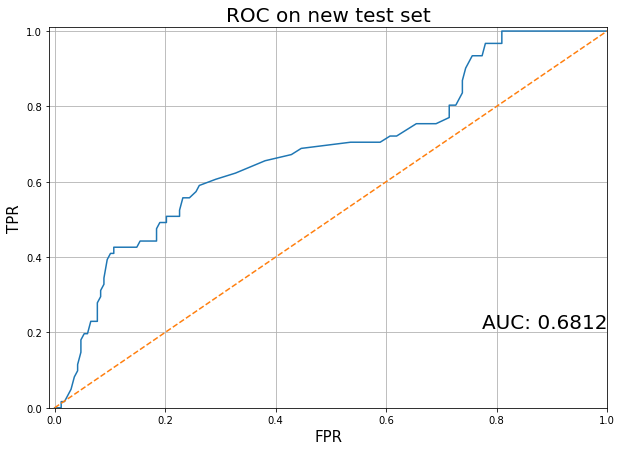

In [15]:
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize= (10,7))
plt.title('ROC on new test set', fontsize=20)
plt.plot(fpr,tpr)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1.)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.text(1, 0.2, 'AUC: ' + str("%.4f" % roc_auc),
        verticalalignment='bottom', horizontalalignment='right', fontsize=20)
# plt.text(1, 0.1, 'Purity: ' + str("%.4f" % purity),
#         verticalalignment='bottom', horizontalalignment='right', fontsize=20)
# plt.text(1, 0, 'Completeness: ' + str("%.4f" % completeness),
#         verticalalignment='bottom', horizontalalignment='right', fontsize=20)
plt.grid(True)

plt.show()

In [27]:
print x_test.shape

(240, 3, 101, 101)


In [17]:
p, c = model.eval_purity_completeness(x_test,y_test)

In [18]:
print p,c

0.764706 0.42623
